In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd



import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from lightgbm import LGBMRegressor
import lightgbm

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
import seaborn as sns
import re

import xgboost as xgb

# optuna

!pip install optuna
import optuna.integration.lightgbm as lgb
import optuna

In [ ]:
Tourney_Compact_Results  = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MNCAATourneyCompactResults.csv')

Tourney_Seeds = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MNCAATourneySeeds.csv')

RegularSeason_Compact_Results = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MRegularSeasonCompactResults.csv')
MSeasons = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MSeasons.csv')
MTeams = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MTeams.csv')
massey = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MMasseyOrdinals.csv')


test = pd.read_csv('/content/drive/MyDrive/kaggle/ncaa/MSampleSubmissionStage1.csv')

In [ ]:
RegularSeason_Results_Compact = pd.merge(RegularSeason_Compact_Results, Tourney_Seeds,
                                   left_on=['Season','WTeamID'], 
                                   right_on=['Season', 'TeamID'], how='left')
RegularSeason_Results_Compact.rename(columns={'Seed':'WinningSeed'},inplace=True)
RegularSeason_Results_Compact= RegularSeason_Results_Compact.drop(['TeamID'],axis=1)

RegularSeason_Results_Compact= pd.merge(RegularSeason_Results_Compact, Tourney_Seeds,
                                  left_on=['Season', 'LTeamID'],
                                  right_on=['Season','TeamID'], how='left')
RegularSeason_Results_Compact.rename(columns={'Seed':'LoosingSeed'}, inplace=True)
R_df=RegularSeason_Results_Compact.drop(['TeamID','NumOT','WLoc'],axis=1)



In [ ]:
R_df['ScoreGap'] = R_df['WScore'] - R_df['LScore']

In [ ]:
num_win = R_df.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season','WTeamID','DayNum']].rename(columns={'DayNum':'NumWins', 'WTeamID':'TeamID'})

num_loss = R_df.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season','LTeamID','DayNum']].rename(columns={'DayNum':'NumLosses', 'LTeamID':'TeamID'})

In [ ]:
gap_win = R_df.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={'ScoreGap':'GapWins', 'WTeamID':'TeamID'})

gap_loss = R_df.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={'ScoreGap':'GapLosses', 'LTeamID':'TeamID'})

In [ ]:
R_df_w = R_df.groupby(['Season','WTeamID']).count().reset_index()[['Season','WTeamID']].rename(columns={'WTeamID':'TeamID'})
R_df_l = R_df.groupby(['Season','LTeamID']).count().reset_index()[['Season','LTeamID']].rename(columns={'LTeamID':'TeamID'})

In [ ]:
R_df_season = pd.concat([R_df_w, R_df_l],0).drop_duplicates().sort_values(['Season','TeamID']).reset_index(drop=True)

In [ ]:
R_df_season = R_df_season.merge(num_win, on=['Season', 'TeamID'], how='left')
R_df_season = R_df_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
R_df_season = R_df_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
R_df_season = R_df_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [ ]:
R_df_season.fillna(0, inplace=True)

In [ ]:
# ratio

R_df_season['WinRatio'] = R_df_season['NumWins'] / (R_df_season['NumWins'] + R_df_season['NumLosses'])

R_df_season['GapAvg'] = ((R_df_season['NumWins'] * R_df_season['GapWins'] - R_df_season['NumLosses'] * R_df_season['GapLosses'])  
                          / (R_df_season['NumWins'] + R_df_season['NumLosses']))

In [ ]:
R_df_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

In [ ]:
def get_round(day):
#     round_dic = {134: 0, 135: 0, 136: 1, 137: 1, 138: 2, 139: 2, 143: 3, 144: 3, 145: 4, 146: 4, 152: 5, 154: 6}
    round_dic = {137: 0, 138: 0, 139: 1, 140: 1, 141: 2, 144: 3, 145: 3, 146: 4, 147: 4, 148: 4, 151:5, 153: 5, 155: 6} # probably wrong but I don't use it anyways
    try:
        return round_dic[day]
    except:
        print(f'Unknow day : {day}')
        return 0

In [ ]:
TR_df = Tourney_Compact_Results
TR_df['Round'] = Tourney_Compact_Results['DayNum'].apply(get_round)

Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 143
Unknow day : 143
Unknow day : 143
Unknow day : 143
Unknow day : 152
Unknow day : 152
Unknow day : 154
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 143
Unknow day : 143
Unknow day : 143
Unknow day : 143
Unknow day : 152
Unknow day : 152
Unknow day : 154
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 1

In [ ]:
TR_df.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [ ]:
df = TR_df.copy()
df = df[df['Season'] >= 2003].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round
0,2003,134,1421,92,1411,84,0
1,2003,136,1112,80,1436,51,0
2,2003,136,1113,84,1272,71,0
3,2003,136,1141,79,1166,73,0
4,2003,136,1143,76,1301,74,0


In [ ]:
df = pd.merge(df, Tourney_Seeds, how='left', left_on = ['Season', 'WTeamID'], 
              right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})


df = pd.merge(df, Tourney_Seeds, how='left', left_on = ['Season', 'LTeamID'], 
              right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [ ]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [ ]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [ ]:
df = pd.merge(
    df,
    R_df_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [ ]:
df = pd.merge(
    df,
    R_df_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [ ]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
        "SeedW": "SeedA", 
        "SeedL": "SeedB",
        'WinRatioW' : 'WinRatioA',
        'WinRatioL' : 'WinRatioB',
        'GapAvgW' : 'GapAvgA',
        'GapAvgL' : 'GapAvgB',
#         "OrdinalRankW": "OrdinalRankA",
#         "OrdinalRankL": "OrdinalRankB",
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
        "SeedW": "SeedB", 
        "SeedL": "SeedA",
        'GapAvgW' : 'GapAvgB',
        'GapAvgL' : 'GapAvgA',
        'WinRatioW' : 'WinRatioB',
        'WinRatioL' : 'WinRatioA',
#         "OrdinalRankW": "OrdinalRankB",
#         "OrdinalRankL": "OrdinalRankA",
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [ ]:
df = add_loosing_matches(df)

In [ ]:
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))

In [ ]:
df_test = pd.merge(
    test,
    Tourney_Seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

In [ ]:
df_test = pd.merge(
    df_test, 
    Tourney_Seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

In [ ]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

In [ ]:
df_test = pd.merge(
    df_test,
    R_df_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [ ]:
df_test = pd.merge(
    df_test,
    R_df_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

In [ ]:
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinRatioDiff'] = df_test['WinRatioA'] - df_test['WinRatioB']
df_test['GapAvgDiff'] = df_test['GapAvgA'] - df_test['GapAvgB']


df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinRatioDiff'] = df['WinRatioA'] - df['WinRatioB']
df['GapAvgDiff'] = df['GapAvgA'] - df['GapAvgB']


In [ ]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [ ]:
#df_train = df.drop(['Season', 'DayNum','TeamIdA','ScoreA','TeamIdB','ScoreB','Round','ScoreDiff','WinA'], axis=1)
#df_Y = df['WinA']

#df_test = df_test.drop(['ID', 'Pred', 'Season', 'TeamIdA','TeamIdB'], axis=1)




In [ ]:
# modeling

features = [
           'SeedA',
           'SeedB',
           'WinRatioA',
           'GapAvgA',
           'WinRatioB',
           'GapAvgB',
           'SeedDiff',
           'WinRatioDiff',
           'GapAvgDiff'
           ]

In [ ]:
# sclase 正規化

def rescale(features, df_train, df_test=None):
    train_min = df_train[features].min()
    train_max = df_train[features].max()
    
    df_train[features] = (df_train[features] - train_min) / (train_max - train_min)

    if df_test is not None:
      test_min = df_test[features].min()
      test_max = df_test[features].max()
      df_test[features] = (df_test[features] - test_min) / (test_max - test_min)

      return df_train[features], df_test[features]
        
    return df_train[features]

In [ ]:
# 交差検証のためのtrainデータとtestデータの作成


train_x, test_x, train_y, test_y = train_test_split(X1, y, test_size=0.25, random_state=0)


# lgbのデータセットに変更

trains = lgb.Dataset(train_x,train_y)
tests  = lgb.Dataset(test_x, test_y)

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
}

# 学習

model = lgb.train(params, trains, valid_sets=tests,
                    verbose_eval=False,
                    num_boost_round=10000000,
                    early_stopping_rounds=10000)

[I 2021-03-06 08:46:34,110] A new study created in memory with name: no-name-3cf932ad-bfb1-434e-9ea5-f63c42a58e49

feature_fraction, val_score: 0.572580:  14%|#4        | 1/7 [00:05<00:34,  5.80s/it][I 2021-03-06 08:46:39,928] Trial 0 finished with value: 0.5725796807995196 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.5725796807995196.

feature_fraction, val_score: 0.572580:  29%|##8       | 2/7 [00:11<00:28,  5.69s/it][I 2021-03-06 08:46:45,340] Trial 1 finished with value: 0.5746603096941074 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.5725796807995196.

feature_fraction, val_score: 0.572580:  43%|####2     | 3/7 [00:17<00:22,  5.74s/it][I 2021-03-06 08:46:51,193] Trial 2 finished with value: 0.5731442837781853 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.5725796807995196.

feature_fraction, val_score: 0.572580:  57%|#####7    | 4/7 [00:23<00:17,  5.91s/it][I 2021-03-06 08:46:57,508] Trial 3 finished 

In [ ]:
best_params = model.params

print("Best params", best_params)

for key, value in best_params.items():
  print("   {}: {}".format(key,value))

Best params {'objective': 'binary', 'metric': 'binary_logloss', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.5, 'bagging_fraction': 0.4889652206719061, 'bagging_freq': 7, 'min_child_samples': 20}
   objective: binary
   metric: binary_logloss
   feature_pre_filter: False
   lambda_l1: 0.0
   lambda_l2: 0.0
   num_leaves: 2
   feature_fraction: 0.5
   bagging_fraction: 0.4889652206719061
   bagging_freq: 7
   min_child_samples: 20


In [ ]:
test_pred = []


kf = KFold(n_splits=5, shuffle=True, random_state=1)

for year in test['Season'].unique():


  X_year = X[X['Season'] < year].copy()
  y_year = X_year['WinA'].copy()
#  X_year = X_year.drop(['ScoreA', "ScoreB","TeamIdA","TeamIdB","ScoreDiff","WinA","Round","DayNum","WinRatioA","WinRatioB","GapAvgA","GapAvgB","WinRatioDiff","GapAvgDiff"], axis=1)
  test_year = test[test['Season'] == year].copy()

  X_year, test_year = rescale(features, X_year, test_year)

  lgbm_val_pred = np.zeros(len(y_year))
  lgbm_test_pred = np.zeros(len(test_year))
  logloss = []

  for trn_idx , val_idx in kf.split(X_year,y_year):
    x_train_idx = X_year.iloc[trn_idx]
    y_train_idx = y_year.iloc[trn_idx]
    x_valid_idx = X_year.iloc[val_idx]
    y_valid_idx = y_year.iloc[val_idx]

    lgbm_model = LGBMRegressor(**best_params)
    lgbm_model.fit(x_train_idx, y_train_idx, eval_set=((x_valid_idx, y_valid_idx)), verbose = False, early_stopping_rounds=100)
    lgbm_test_pred += lgbm_model.predict(test_year)/5

    logloss.append(log_loss(y_valid_idx, lgbm_model.predict(x_valid_idx)))

  test_pred += lgbm_test_pred.tolist()

  print('Year_Predict:',year,'Log_Loss:', np.mean(logloss))

Year_Predict: 2015 Log_Loss: 0.5520743027879145
Year_Predict: 2016 Log_Loss: 0.550127277548278
Year_Predict: 2017 Log_Loss: 0.5519592049320303
Year_Predict: 2018 Log_Loss: 0.5515633924821642
Year_Predict: 2019 Log_Loss: 0.552810834148999


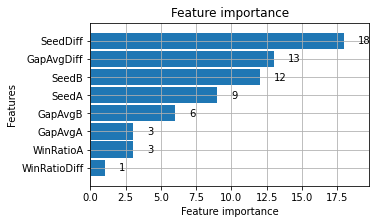

In [ ]:
plt.rcParams["figure.figsize"] = (5, 3)
lightgbm.plot_importance(lgbm_model,height=.9)

In [ ]:
print(test)

                   ID      Pred  Season  ...  SeedDiff  WinRatioDiff  GapAvgDiff
0      2015_1107_1112  0.121648    2015  ...  0.900000      0.358824    0.210339
1      2015_1107_1116  0.295594    2015  ...  0.800000      0.508145    0.418115
2      2015_1107_1124  0.255868    2015  ...  0.866667      0.554808    0.398675
3      2015_1107_1125  0.501493    2015  ...  0.466667      0.596774    0.507349
4      2015_1107_1129  0.360758    2015  ...  0.600000      0.531266    0.396104
...               ...       ...     ...  ...       ...           ...         ...
11385  2019_1449_1459  0.361008    2019  ...  0.566667      0.419548    0.300562
11386  2019_1449_1463  0.495492    2019  ...  0.333333      0.538009    0.436167
11387  2019_1458_1459  0.434075    2019  ...  0.433333      0.350769    0.346443
11388  2019_1458_1463  0.781704    2019  ...  0.200000      0.469231    0.482048
11389  2019_1459_1463  0.721888    2019  ...  0.266667      0.641538    0.608085

[11390 rows x 14 columns]


In [ ]:
# 提出

sub = test[['ID', 'Pred']].copy()
sub['Pred'] = test_pred
sub.to_csv('submission.csv', index=False)



In [ ]:

from google.colab import files
sub.to_csv("output.csv")
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

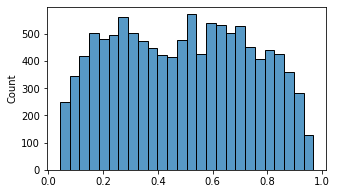

In [ ]:
_ = sns.histplot(test_pred)